In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

In [2]:
import numpy as np
import pylab as plt
import sounddevice as sd
from scipy import signal as sg
import seaborn as sns
from ipywidgets import interactive

plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150
plt.rcParams['axes.grid'] = True

## Линейные системы
Система $S$ называется линейной если: 
$$S(a_1x_1[n] + a_2x_2[n]) = a_1S(x_1[n]) + a_2S(x_2[n])$$

Какие из следующих систем являются линейными?
1. $y[n] = x[n-n_d]$

1. $y[n] = x[n] + 1$

2. $y[n] = \frac{1}{M_l + M_R + 1}\sum_{k=-M_l}^{M_r}x[n-k]$

3. $y[n] = x^2[n]$

### Примеры
#### Сумматор (является линейной системой):

$y[n] = \sum_{k=-\infty}^{n}x[k]$

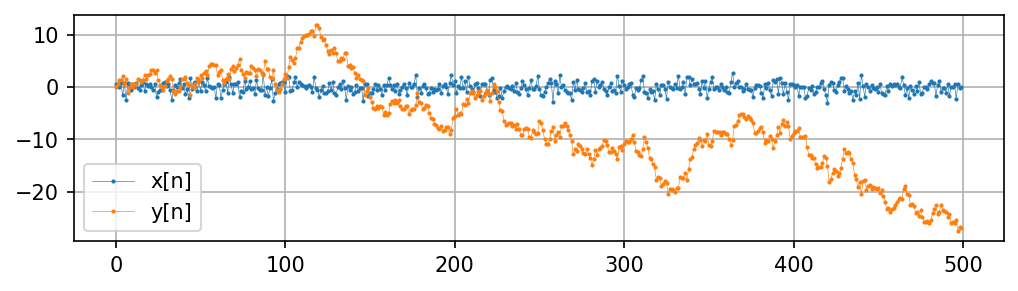

In [3]:
def accumulator(x):
    y = [sum(x[:n]) for n in range(len(x))]
    return np.array(y)

x = np.random.normal(size=500)
y = accumulator(x)

plt.figure()
plt.plot(x, '.-', label='x[n]', linewidth=0.3, markersize=2)
plt.plot(y, '.-', label='y[n]', linewidth=0.3, markersize=2)
plt.legend()

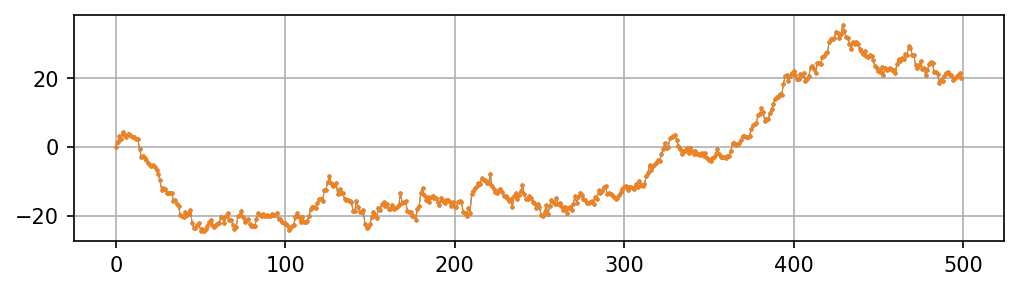

In [4]:
np.random.seed(42)
x1 = np.random.normal(size=500)
x2 = np.random.normal(size=500)
plt.plot(accumulator(x1) + accumulator(x2), '.-', label='y(x1[n]) + y(x2[n])', linewidth=0.5, markersize=2)
plt.plot(accumulator(x1+x2), '.-', label='y(x1[n]) + y(x2[n])', linewidth=0.5, markersize=2)

#### Логарифм  (не является линейной системой):

$y[n] = log_{10}(|x[n]|+0.00001)$

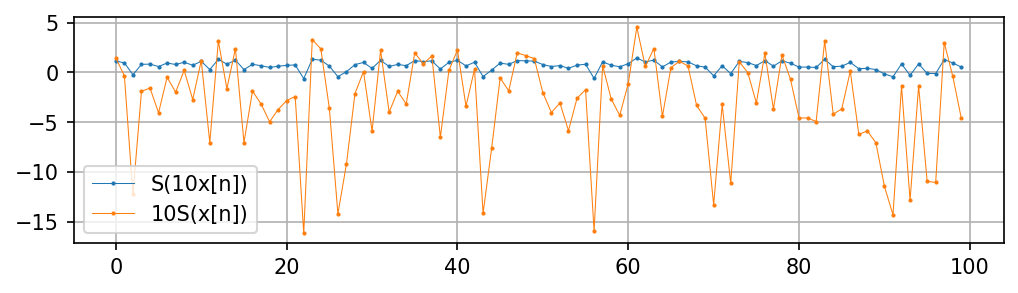

In [5]:
def log10(x):
    y = np.log10(np.abs(x)+0.00001)
    return np.array(y)

x = np.random.normal(size=100)
#plt.plot(x, '.-', alpha=0.3, label='x[n]')

plt.figure()
plt.plot(log10(10*x), '.-', label='S(10x[n])', linewidth=0.5, markersize=2)
plt.plot(10*log10(x), '.-', label='10S(x[n])', linewidth=0.5, markersize=2)
plt.legend()

### Стационарность
$y[n] = S(x[n])$

$S(x[n-n_0]) = y[n-n_0]$, $\forall n_0: -\infty < n_0 < \infty$

#### Стационарность сумматора:

$y[n] = \sum_{k=-\infty}^{n}x[k]$

$y[n-n_0] = \sum_{k=-\infty}^{n-n0}x[k] = \sum_{k'=-\infty}^{n}x[k'-n_0] = S(x[n - n_0])$

$k' = k + n_0$

Для верхней границы суммы $k=n - n_0$, $k'=n$

#### Уплотнитель:
$ y[n] = S(x[n]) = x[2n]$

Let $k=2n$:

$~~~y[n] = x[k]$

$~~~y[n-n_0] = x[k-n_0] = \color{red}{x[2n-n_0]}$

Let $l=n-n_0$:

$~~~S(x[n-n_0]) = S(x[l]) = x[2l] = \color{red}{x[2(n - n_0)]}$



### Каузальность
$y[n] = S(x[n]) = f(x[n], x[n-1], x[n-2], ...)$


Примеры:

$S_1$: $y[n] = x[n+1] - x[n]$

$S_2$: $y[n] = x[n] - x[n-1]$

### Устойчивость

$|x[n]| \le B_x <\infty$ $\forall n $

$|y[n]| \le B_y <\infty$ $\forall n $


Примеры:
1. $y[n] = x^2[n]$
2. $y[n] = \sum_{k=-\infty}^{n}x[k]$

(-10.0, 10.0)

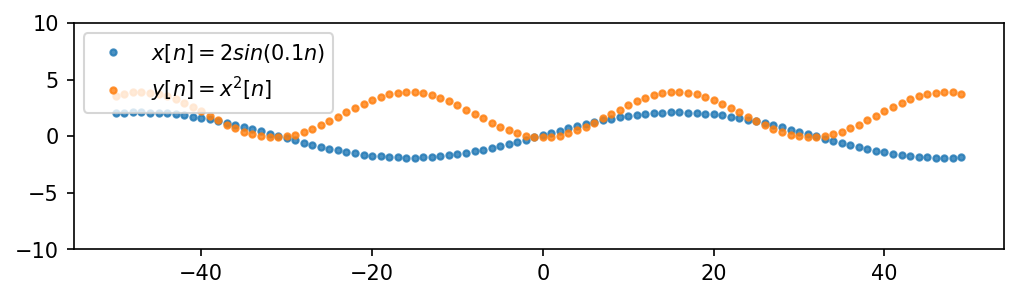

In [6]:
n = np.arange(-50, 50)
x = 2*np.sin(n/10)
y = x**2

plt.plot(n, x+0.1, '.', alpha=0.8, label='$x[n] = 2sin(0.1n)$')
plt.plot(n, y-0.1, '.', alpha=0.8, label='$y[n] = x^2[n]$')
plt.legend(loc=2)
plt.grid()
plt.ylim(-10, 10)

(-1.0, 10.0)

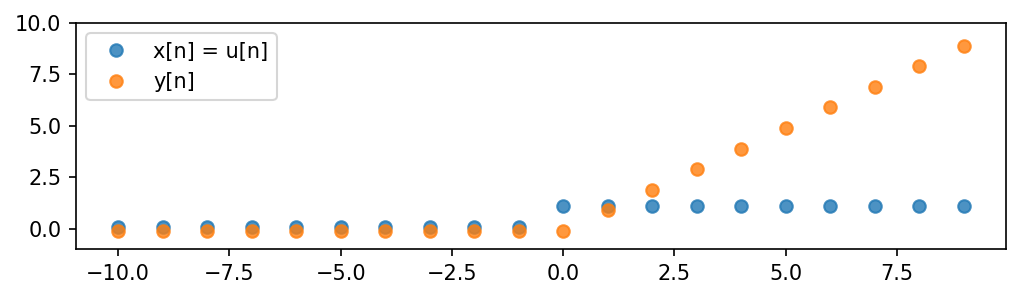

In [7]:
n = np.arange(-10, 10)
x = (n >= 0).astype(int)
y = accumulator(x)

plt.plot(n, x+0.1, 'o', alpha=0.8, label='x[n] = u[n]')
plt.plot(n, y-0.1, 'o', alpha=0.8, label='y[n]')
plt.legend(loc=2)
plt.grid()
plt.ylim(-1, 10)

## Линейная стационарная система
Система $S$ называется линейной стационарная системой (LTI) если:
1. $S(a_1x_1[n] + a_2x_2[n]) = a_1S(x_1[n]) + a_2S(x_2[n])$
2. $y[n] = S(x[n]) \Rightarrow S(x[n-n_0]) = y[n-n_0]$, $\forall n_0: -\infty < n_0 < \infty$

Напоминание:

$x[n] = \sum_{k=-\infty}^\infty x[k]\delta[n-k]$

Пусть $S$ - LTI. Тогда:

$y[n] = S(x[n]) = S\Big(\sum_{k=-\infty}^\infty x[k]\delta[n-k]\Big) = $

$ = \sum_{k=-\infty}^\infty x[k]S(\delta[n-k]) = $

$ = \sum_{k=-\infty}^\infty x[k]h[n-k]$

Свертка:

$ y[n] = x[n]*h[n]$

$h[n]$ - *импульсная характеристика системы*

In [8]:
def pad(domain, n, domain_start=0):
    x = np.zeros(len(n))
    start = np.where(n==domain_start)[0][0]
    x[start:start+len(domain)] = domain
    return x

def pad_reverse_and_shift(domain, n, shift=0, domain_start=0):
    x = np.zeros(len(n))
    start = np.where(n==domain_start)[0][0]
    x[start-len(domain)+1+shift:start+1+shift] = domain[::-1]
    return x
        
    

n = np.arange(-5, 10)
x_domain = [-1, -0.5, 0, 0.5, 1]
h_domain = [1, -1]


def plot_conv(m=-3):
    x = pad(x_domain, n)
    h = pad(h_domain, n)
    h_nmk = pad_reverse_and_shift(h_domain, n, m)
    y = np.convolve(pad(x_domain, n), h_domain, 'same')

    fig, axes = plt.subplots(3, figsize=(8, 6), sharex='all', sharey='all')
    axes[1].plot(n+0.05, x, 'oC0', label='$x[k]$')
    axes[0].plot(n+0.05, x, 'oC0', label='$x[n]$')
    axes[0].plot(n-0.05, h, 'oC1', label='$h[n]$')
    axes[1].plot(n-0.05, h_nmk, 'oC3', label='$h[{}-k]$'.format(m))
    axes[1].plot(n, h_nmk*x, 'xk', label='$x[k]\cdot h[{}-k]$'.format(m), markersize=4)
    axes[2].plot(n, y, 'oC2', label='$y[n]$')
    axes[2].plot(m, sum(x*h_nmk), 'xC3', label='$y[{}]$'.format(m), markersize=10)
    axes[0].legend(loc=4), axes[1].legend(loc=4), axes[2].legend(loc=4) 
    [ax.axvline(m, zorder=-100, color='k', alpha=0.5, linestyle='--') for ax in axes]
    sns.despine()
    plt.show()


interactive_plot = interactive(plot_conv, m=(-3, 7, 1))
output = interactive_plot.children[-2]
interactive_plot

interactive(children=(IntSlider(value=-3, description='m', max=7, min=-3), Output()), _dom_classes=('widget-in…

## Итог
### Линейная стационарная система
Система $S$ называется линейной стационарная системой (LTI) если:
> 1. $S(a_1x_1[n] + a_2x_2[n]) = a_1S(x_1[n]) + a_2S(x_2[n])$
> 2. $y[n] = S(x[n]) \Rightarrow S(x[n-n_0]) = y[n-n_0]$, $\forall n_0: -\infty < n_0 < \infty$

Напоминание: 
> $x[n] = \sum_{k=-\infty}^\infty x[k]\delta[n-k]$

Пусть $S$ - LTI. Тогда:

> $y[n] = S(x[n]) = S\Big(\sum_{k=-\infty}^\infty x[k]\delta[n-k]\Big) = $

> $ = \sum_{k=-\infty}^\infty x[k]S(\delta[n-k]) = $

> $ = \sum_{k=-\infty}^\infty x[k]h[n-k]$

Свертка:

> $ y[n] = x[n]\star h[n]$

$h[n]$ - *импульсная характеристика системы*

$\star$ - *операция свертки*

#### Примеры

###### Идеальная система задержки:
> $y[n] = S_d(x[n]) = x[n-d]$

> $h[n] = S(\delta[n]) = \delta[n-d]$

> $y[n] = x[n] \star h[n] = \sum_{k=-\infty}^\infty x[k]h[n-k] = $

> $ = \sum_{k=-\infty}^\infty x[k]\delta[n-d-k] = x[n-d]$

###### Скользящее среднее 

> $y[n] = S(x[n]) = \frac{1}{3}\sum_{k=-1}^{1}x[n-k]$

> $h[n] = S(\delta[n]) = \frac{1}{3}\sum_{k=-1}^{1}\delta[n-k] = \frac{1}{3}\delta[n-1] + \frac{1}{3}\delta[n] + \frac{1}{3}\delta[n+1] $

> $y[n] = x[n]\star h[n] = \sum_{k=-\infty}^\infty x[k]h[n-k] =$

> $= \sum_{k=-\infty}^\infty x[k](\frac{1}{3}\delta[n-1-k] + \frac{1}{3}\delta[n-k] + \frac{1}{3}\delta[n+1-k]) = $

> $= \frac{1}{3}x[n-1] + \frac{1}{3}x[n] + \frac{1}{3}x[n+1]= \frac{1}{3}\sum_{k=-1}^{1}x[n-k]$

## Свойства LTI систем
LTI система полностью описывается импульсной характеристикой $h[n]$


$y[n] = S\Big(x[n]\Big) = x[n]\star h[n] = \sum\limits_{k=-\infty}^\infty x[k]\cdot h[n-k] $

In [9]:
def pad(domain, n, domain_start=0):
    x = np.zeros(len(n))
    start = np.where(n==domain_start)[0][0]
    x[start:start+len(domain)] = domain
    return x

def pad_reverse_and_shift(domain, n, shift=0, domain_start=0):
    x = np.zeros(len(n))
    start = np.where(n==domain_start)[0][0]
    x[start-len(domain)+1+shift:start+1+shift] = domain[::-1]
    return x
        
    

n = np.arange(-5, 10)
x_domain = [-1, -0.5, 0, 0.5, 1]
h_domain = [1, -1]


def plot_conv(m=-3):
    x = pad(x_domain, n)
    h = pad(h_domain, n)
    h_nmk = pad_reverse_and_shift(h_domain, n, m)
    y = np.convolve(pad(x_domain, n), h_domain, 'same')

    fig, axes = plt.subplots(3, figsize=(8, 6), sharex='all', sharey='all')
    axes[1].plot(n+0.05, x, 'oC0', label='$x[k]$')
    axes[0].plot(n+0.05, x, 'oC0', label='$x[n]$')
    axes[0].plot(n-0.05, h, 'oC1', label='$h[n]$')
    axes[1].plot(n-0.05, h_nmk, 'oC3', label='$h[{}-k]$'.format(m))
    axes[1].plot(n, h_nmk*x, 'xk', label='$x[k]\cdot h[{}-k]$'.format(m), markersize=4)
    axes[2].plot(n, y, 'oC2', label='$y[n]$')
    axes[2].plot(m, sum(x*h_nmk), 'xC3', label='$y[{}]$'.format(m), markersize=10)
    axes[0].legend(loc=4), axes[1].legend(loc=4), axes[2].legend(loc=4) 
    [ax.axvline(m, zorder=-100, color='k', alpha=0.5, linestyle='--') for ax in axes]
    sns.despine()
    plt.show()


interactive_plot = interactive(plot_conv, m=(-3, 7, 1))
output = interactive_plot.children[-2]
interactive_plot

interactive(children=(IntSlider(value=-3, description='m', max=7, min=-3), Output()), _dom_classes=('widget-in…

## Свойства свертки:

1. Коммутативность $a[n]\star b[n]=b[n]\star a[n]$. 
2. Дистрибутивность $x[n]\star \Big(h_1[n] + h_2[n]\Big)$ =  $x[n]\star h_1[n] + x[n]\star h_2[n]$
3. Ассоциативность $\Big(x[n]\star h_1[n]\Big)\star h_2[n] = x[n]\star \Big(h_1[n]\star h_2[n]\Big)$


## Комбинация LTI систем
Как следствие последовательность применения LTI систем не важна:

> $y_1[n] = S_{1}\Big(x[n]\Big) = x[n]\star h_1[n]$

> $y_2[n] = S_{2}\Big(y_1[n]\Big) = y_1[n]\star h_2[n]$

> $y_2[n] = \Big(x[n]\star h_1[n]\Big)\star h_2[n] = x[n]\star \Big(h_1[n]\star h_2[n]\Big) = x[n]\star \Big(h_2[n]\star h_1[n]\Big) = \Big(x[n]\star h_2[n]\Big)\star h_1[n]$

### Вопрос

Как связана испульсная характеристика $h_{12}[n]$ системы $y_2[n] = S_{12}\Big(x[n]\Big) = S_{2}\Big(S_1(x[n])\Big)$ с испульсными характеристиками $h_1[n]$ и $h_2[n]$?

.

.

.

*Ответ:* 

> $h_{12}[n] = h_{1}[n]\star h_{2}[n]$




### Пример

1. Идеальная система задержки на 2 отсчета: $$h_1[n] = \delta[n-2]$$

2. Скользящее среднее с симметричным окном в 3 отсчета: $$h_2[n] = \frac{1}{3}\Big(\delta[n-1] + \delta[n] + \delta[n+1]\Big) $$

Комбинация систем 1 и 2:

$h_{12} = h_{2}[n]\star h_{1}[n] = \frac{1}{3}\Big(\delta[n-1] + \delta[n] + \delta[n+1]\Big) \star \delta[n-2]$

$h_{12} = \sum\limits_{k=-\infty}^\infty \frac{1}{3}\Big(\delta[k-1] + \delta[k] + \delta[k+1]\Big)\cdot \delta[n-2-k]$

$h_{12} = \frac{1}{3}\Big(\delta[n-3] + \delta[n-2] + \delta[n-1]\Big)$